In [1]:
import scipy.interpolate
import astropy.table
import numpy
import time
import glob

def read_pms_data(tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    path = './evolutionary_tracks/'
    
    if tracks == "BHAC15":
        f = open(path+"BHAC15_tracks+structure.txt","r")
        lines = f.readlines()
        f.close()

        colnames = lines[46].split()[1:]

        data = numpy.loadtxt(path+"BHAC15_tracks+structure.txt", comments="!", \
                skiprows=45)
    elif tracks == "Siess2000":
        f = open(path+"siess_2000/m0.13z02.hrd")
        lines = f.readlines()
        f.close()

        line1 = lines[0].replace(" (","_(").replace("log g","logg").\
                replace("#","").replace("_(Lo)","/Ls").replace("age_","log_t").\
                split()
        line2 = lines[1].replace(" (","_(").replace("log g","logg").\
                replace("#","").replace("_(Mo)","/Ms").split()

        colnames = line1 + line2
        colnames[0::2] = line1
        colnames[1::2] = line2

        files = glob.glob(path+"siess_2000/*.hrd")
        for file in files:
            try:
                data = numpy.concatenate((data, numpy.loadtxt(file)))
            except:
                data = numpy.loadtxt(file)

        # Fix the stellar luminosity.

        data[:,2] = numpy.log10(data[:,2])
        data[:,-1] = numpy.log10(data[:,-1])
    elif tracks == "Dotter2008":
        f = open(path+"dotter2008/m200fehp00afep0.trk")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[1].replace("Log ","Log").\
                replace("Age ","log_t").replace("LogT","Teff").\
                replace("LogL","L/Ls").replace("yrs","yr").split()[1:]

        # Now read in the data files.

        files = glob.glob(path+"dotter2008/*.trk")
        for file in files:
            new_data = numpy.loadtxt(file)

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1][1:4])/100.
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Get rid of ages more than ~50Myr.

        good = data[:,1] < 50.0e6
        data = data[good,:]

        # Fix some of the columns.

        data[:,1] = numpy.log10(data[:,1])
        data[:,2] = 10.**data[:,2]

    elif tracks == "Tognelli2011":
        f = open(path+"tognelli2011/Z0.02000_Y0.2700_XD2E5_ML1.68_AS05/"
                "TRK_M0.20_Z0.02000_Y0.2700_XD2E5_ML1.68_AS05.DAT")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[3].replace("LOG ","LOG_").\
                replace("LOG_AGE","log_t(yr)").replace("LOG_L","L/Ls").\
                replace("LOG_TE","Teff").split()[1:]

        # Now read in the data files.

        files = glob.glob(path+"tognelli2011/"
                "Z0.02000_Y0.2700_XD2E5_ML1.68_AS05/*.DAT")
        for file in files:
            new_data = numpy.loadtxt(file)

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1].split("_")[1][1:])
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Fix some of the columns.

        data[:,5] = 10.**data[:,5]

    elif tracks == "Feiden2016":
        f = open(path+"feiden2016/std/"
                "m0090_GS98_p000_p0_y28_mlt1.884.trk")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[3].replace("Log ","Log").\
                replace("Age ","log_t").replace("LogT","Teff").\
                replace("LogL","L/Ls").replace("yrs","yr").split()[1:6]

        # Now read in the data files.

        files = glob.glob(path+"feiden2016/std/*.trk")
        for file in files:
            new_data = numpy.loadtxt(file, usecols=(0,1,2,3,4))

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1][1:5])/1000.
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Get rid of ages more than ~50Myr.

        good = data[:,1] < 50.0e6
        data = data[good,:]

        # Fix some of the columns.

        data[:,1] = numpy.log10(data[:,1])
        data[:,2] = 10.**data[:,2]

    elif tracks == "Feiden2016mag":
        f = open(path+"feiden2016/mag/"
                "m1700_GS98_p000_p0_y28_mlt1.884_mag08kG.ntrk")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[8].replace("conv. ","conv.").\
                replace("AGE","log_t(yr)").replace("log(Teff)","Teff").\
                replace("log(L/Lsun)","L/Ls").replace("Model #","Model#").\
                replace("M He core","M_He_core").replace(",","").split()[1:]

        # Now read in the data files.

        files = glob.glob(path+"feiden2016/mag/*.ntrk")
        for file in files:
            new_data = numpy.loadtxt(file,usecols=tuple([i for i in range(12)]))

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1][1:5])/1000.
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Fix some of the columns.

        data[:,3] = numpy.log10(data[:,3]*1.0e9)
        data[:,7] = 10.**data[:,7]

    elif tracks == "Chen2014":
        f = open(path+"bressan2012/Z0.017Y0.279/"
                "Z0.017Y0.279OUTA1.77_F7_M000.700.DAT")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = lines[0].replace("LOG ","LOG_").\
                replace("AGE","log_t(yr)").replace("LOG_L","L/Ls").\
                replace("LOG_TE","Teff").replace("MASS","M/Ms").split()

        # Now read in the data files.

        files = glob.glob(path+"bressan2012/Z0.017Y0.279/*.DAT")

        for file in files:
            new_data = numpy.loadtxt(file, skiprows=2)

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Get rid of ages more than ~50Myr.

        good = data[:,2] < 50.0e6
        data = data[good,:]

        # Fix some of the columns.

        data[:,2] = numpy.log10(data[:,2])
        data[:,4] = 10.**data[:,4]

    elif tracks == "Bressan2012":
        f = open(path+"bressan2012/bressan2012.dat")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = lines[13].replace("log(age/yr)","log_t(yr)").\
                replace("logL/Lo","L/Ls").replace("logTe","Teff").\
                replace("M_act","M/Ms").split()[1:]

        # Now read in the data files.

        data = numpy.loadtxt(path+"bressan2012/bressan2012.dat")

        # Fix some of the columns.

        data[:,5] = 10.**data[:,5]

    # Make the data into a table.

    table = astropy.table.Table(data, names=colnames)

    # Return the table now.

    return table


def pms_get_mstar(age=None, luminosity=None, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Mstar = scipy.interpolate.LinearNDInterpolator((table["L/Ls"], \
            table["log_t(yr)"]), table["M/Ms"], rescale=True)

    # Finally, get the stellar mass.

    if isinstance(age,float) and isinstance(luminosity,float):
        xi = numpy.array([[luminosity, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[luminosity[i],numpy.log10(age)] for i in range(len(luminosity))])
    else:    
        xi = numpy.array([[luminosity[i],numpy.log10(age[i])] for i in \
                range(len(age))])

    return Mstar(xi)

def pms_get_teff(luminosity = None, age=1.0e6, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Teff = scipy.interpolate.LinearNDInterpolator((table["L/Ls"], \
            table["log_t(yr)"]), table["Teff"])

    # Finally, get the stellar mass.

    if isinstance(age,float) and isinstance(luminosity,float):
        xi = numpy.array([[luminosity, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[luminosity[i],numpy.log10(age)] for i in range(len(mass))])
    else:
        xi = numpy.array([[luminosity[i],numpy.log10(age[i])] for i in range(len(age))])

    return Teff(xi)

def pdspy_get_teff(mass=1.0, age=1.0e6, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Teff = scipy.interpolate.LinearNDInterpolator((table["M/Ms"], \
            table["log_t(yr)"]), table["Teff"])

    # Finally, get the stellar mass.
    
    if isinstance(age,float) and isinstance(mass,float):
        xi = numpy.array([[mass, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[mass[i],numpy.log10(age)] for i in range(len(mass))])
    else:
        xi = numpy.array([[mass,numpy.log10(age[i])] for i in range(len(age))])

    return Teff(xi)

def pdspy_get_luminosity(mass=1.0, age=1.0e6, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Lstar = scipy.interpolate.LinearNDInterpolator((table["M/Ms"],\
            table["log_t(yr)"]), table["L/Ls"])

    # Finally, get the stellar mass.
    print('test')
    if isinstance(age,float) and isinstance(mass,float):
        xi = numpy.array([[mass, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[mass[i],numpy.log10(age)] for i in range(len(mass))])
    else:
        xi = numpy.array([[mass,numpy.log10(age[i])] for i in range(len(age))])
    print('test_end')
    return 10.**Lstar(xi)
        

In [24]:
import numpy as np
import numpy.random as random
import statistics
import matplotlib.pyplot as plt
from matplotlib import colors

def monte_carlo(flux=5.6e-2, D=0.4):
    b = random.normal(-2.66, 0.06, 1000)
    m = random.normal(0.91, 0.06, 1000)
    flux_al = random.normal(flux, 0.1*flux, 1000)
    L_bol_al = []

    lum = flux_al * (D**2)
    for i in range(1000):
        L_bol_al.append((np.log10(lum[i]) - b[i])/m[i])
    L_bol_mean = statistics.mean(L_bol_al)
    L_bol_std = statistics.stdev(L_bol_al)
    return L_bol_al, L_bol_mean, L_bol_std
    
def plot_hist(flux, arr, mean, typ='exponent'):
    N, bins, patches = plt.hist(arr, bins=100)
    max_index = np.argmax(N)
    max_value = bins[max_index]

    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label = 'average')
    plt.axvline(max_value, color='b', linestyle='dashed', linewidth=1, label = 'most frequent')
    plt.legend()
    if typ =='exponent':
        plt.xlabel('exponent of L_bol')
        plt.ylabel('frequency')
        print(f'most frequent result for {flux} mJy is: {max_value}')
    elif typ =='mass':
        plt.xlabel('mass of the object')
        plt.ylabel('frequency')
        print(f'most frequent result for {flux} mJy is: {max_value} solar mass')
    return max_value

In [7]:
def find_flux(flux, lam_in, lam_out, exp=-0.1):
    f_in = 3.0e8/lam_in
    f_out = 3.0e8/lam_out
    return flux*(f_out/f_in)**(exp)
    

In [36]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [53]:
lam_in = 3.0e8/(33.0e9)
lam_out = 4.1e-2
fluxin = 5.69e-5
flux_41_01 = find_flux(fluxin*1000, lam_in, lam_out, -0.1)
flux_41_051 = find_flux(fluxin*1000, lam_in, lam_out, 0.51)

In [56]:
trac = ["BHAC15","Siess2000",  "Dotter2008", "Tognelli2011","Feiden2016","Feiden2016mag","Chen2014","Bressan2012"]
L_bol_1y, L_mean_1y, L_std_1y = monte_carlo(flux=flux_41_051, D=0.4)
mass_al_trac_1y = np.empty(len(trac), dtype=object)
for track in trac: 
    mass_al_trac_1y[trac.index(track)] = pms_get_mstar(age = 1.e6, luminosity= L_bol_1y, tracks=track)

L_bol_1yn, L_mean_1yn, L_std_1yn = monte_carlo(flux=flux_41_01, D=0.4)
mass_al_trac_1yn = np.empty(len(trac), dtype=object)
for track in trac:
    mass_al_trac_1yn[trac.index(track)] = pms_get_mstar(age = 1.e6, luminosity= L_bol_1yn, tracks=track)


<IPython.core.display.Javascript object>


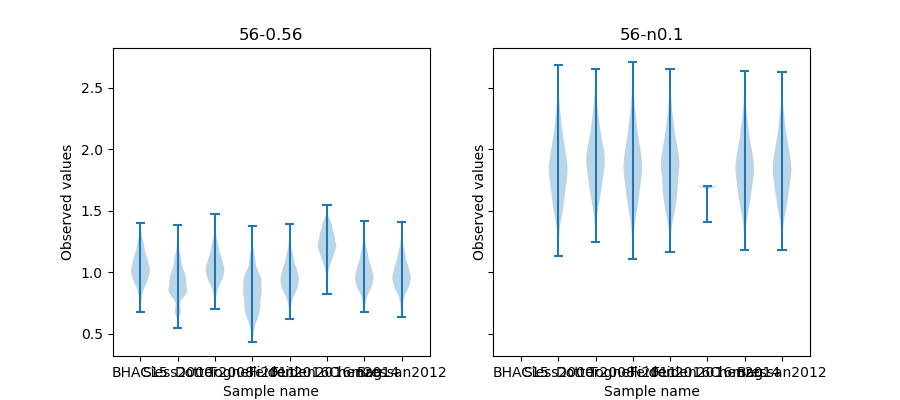

In [58]:
%matplotlib notebook
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)
ax1.set_title('56-0.56')
ax1.set_ylabel('mass/M_sun')
ax1.violinplot(mass_al_trac_1y)
ax2.set_title('56-n0.1')
ax2.set_ylabel('mass/M_sun')
ax2.violinplot(mass_al_trac_1yn)
labels = ["BHAC15","Siess2000",  "Dotter2008", "Tognelli2011","Feiden2016","Feiden2016mag","Chen2014","Bressan2012"]

for ax in [ax1, ax2]:
    set_axis_style(ax, labels)

In [19]:
err_u = []
err_b = []
m_mean = []
for track in trac:
    p_95 = (np.percentile(mass_al_trac_41[trac.index(track)],95))
    p_5 = (np.percentile(mass_al_trac_41[trac.index(track)],5))
    p_50 =(np.percentile(mass_al_trac_41[trac.index(track)],50))
    err_u.append(p_95 - p_50)
    err_b.append(p_50 - p_5)
    m_mean.append(p_50)
    

In [20]:
print(m_mean)
print(err_u)
print(err_b)

[0.8918895320540656, 0.7450431890002447, 0.9017840612004888, 0.6342731635675547, 0.8225000677867447, 1.0875091222452158, 0.8406404186745731, 0.8401682142308344]
[0.16459637572407537, 0.19098743058791934, 0.15519418161970133, 0.23723300431900218, 0.15537652269522895, 0.165345014498109, 0.1549874844944733, 0.15414902254518215]
[0.13354292140838186, 0.12613019742713905, 0.12633726710177273, 0.14817861826715517, 0.12343700196999208, 0.15547012467161025, 0.11272129313530022, 0.1272441089978863]


0
1
2
3
4
5
6
7


Text(0.5, 1.0, '163')

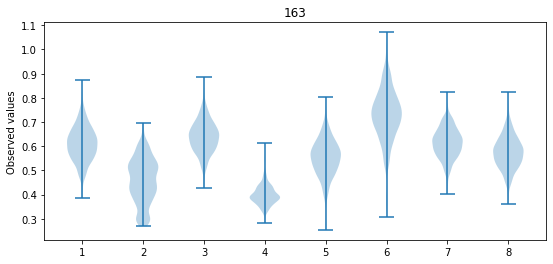

In [32]:
flux_41_01 = find_flux(3*8.75e-3, lam_in, lam_out, -0.1)
flux_41_051 = find_flux(3*8.75e-3, lam_in, lam_out, 0.51)
lam_in = 3.0e8/(44.0e9)
lam_out = 4.1e-2
trac = ["BHAC15","Siess2000",  "Dotter2008", "Tognelli2011","Feiden2016","Feiden2016mag","Chen2014","Bressan2012"]
L_bol_41, L_mean_41, L_std_41 = monte_carlo(flux=flux_41_051, D=0.4)
mass_al_trac_41 = np.empty(len(trac), dtype=object)
for track in trac:
    print(trac.index(track))
    mass_al_trac_41[trac.index(track)] = pms_get_mstar(age = 1.e6, luminosity= L_bol_41, tracks=track)
    
# print(mass_al_trac_41[0])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)
ax.set_title('Default violin plot')
ax.set_ylabel('Observed values')
ax.violinplot(mass_al_trac_41)
ax.set_title('163')

In [ ]:
flux_41_01 = find_flux(8.75e-3, lam_in, lam_out, -0.1)
flux_41_051 = find_flux(0.15, lam_in, lam_out, 0.51)
lam_in = 3.0e8/(345.0e9)
lam_out = 4.1e-2
trac = ["BHAC15","Siess2000",  "Dotter2008", "Tognelli2011","Feiden2016","Feiden2016mag","Chen2014","Bressan2012"]
L_bol_41, L_mean_41, L_std_41 = monte_carlo(flux=flux_41_051, D=0.4)
mass_al_trac_41 = np.empty(len(trac), dtype=object)
for track in trac:
    print(trac.index(track))
    mass_al_trac_41[trac.index(track)] = pms_get_mstar(age = 1.e6, luminosity= L_bol_41, tracks=track)
    
# print(mass_al_trac_41[0])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)
ax.set_title('Default violin plot')
ax.set_ylabel('Observed values')
ax.violinplot(mass_al_trac_41)
ax.set_title('270')